In [21]:
import pandas as pd
import re
import time
import string
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load dataset
tweets_us_df = pd.read_csv("tweets_us_states.csv")
tweets_us_df = tweets_us_df.sample(n=500000,random_state=42)
us_states_df = pd.read_excel("us_states.xlsx")

# Question 1:

In [3]:
#This cell will take about 15 minutes because I cramped a lot of things in it
start_time = time.time()

#Convert string to lowercase
tweets_us_df["location"]= tweets_us_df.location.str.lower()
us_states_df["state"]= us_states_df.state.str.lower()

#Create empty state column for later use.
tweets_us_df['state'] = None

#Extract only location column from main dataset 
new = pd.DataFrame(tweets_us_df["location"])
new[0] = 0

#Check locations with state information
for i, row in new['location'].items():
    text = re.split(r"[^a-zA-Z0-9\s]", row) #Remove all special characters and split locations
    for j, word in enumerate(text): #Remove any entries with length = 0 and spacebars as the start of string
        if len(word)>0:
            if word[0] == ' ':
                text[j] = word[1:]
    for n in text: #Check if state information is in location
        if n in us_states_df['state'].values:
            new[0][i] += 1
            tweets_us_df['state'][i] = n
new.drop(new[new[0] != 1].index, inplace = True) #Drop all entries with zero or more than one state information

indecies = list(new.index)
tweets_us_df = tweets_us_df.loc[indecies] #Keep only rows with one state information

print("Number of observations in the updated dataset: " + str(len(tweets_us_df)))
print("Percentage of data lost: " + str((500000 - len(tweets_us_df)) / 500000 * 100) + "%")

elapsed_time = time.time() - start_time
print("Total computational time: " + str(elapsed_time) + " seconds.")

Number of observations in the updated dataset: 265203
Percentage of data lost: 46.9594%
Total computational time: 972.0573508739471 seconds.


# Question 2:

In [4]:
start_time = time.time()

#Add region column
tweets_us_df = tweets_us_df.merge(us_states_df, on='state', how='left')

#Split and take only the date of the tweet
day = tweets_us_df["created_at"].str.split(" ", n = 1, expand = True)
tweets_us_df["day"] = day[0].astype('datetime64')

elapsed_time = time.time() - start_time
print("Total computational time: " + str(elapsed_time) + " seconds.")

Total computational time: 1.9832346439361572 seconds.


# Question 3:

In [5]:
stopwords = stopwords.words('english')

def tweet_cleaner(tweet):
    tweet = tweet.lower() #Convert to lowercase 
    tweet = tweet.translate(str.maketrans('', '', string.punctuation.replace('#', ''))) #Remove all punctuation except '#'
    out = ""
    for i in tweet.split(): #Split the tweet into individual words
        if i not in stopwords and len(i)>3 and i[0] != '#' and i[:4] != 'http' and '\\' not in i: #If word is not a stopword, have more than 3 characters, not start with hashtag, is not a link, and is not an emoji at the same time then keep this word
            out += i + ' '
    return out[:-1]

# Question 4:

In [6]:
start_time = time.time()
df = tweets_us_df

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

#Lemmatize each word in tweet and return output to 'text_clean' column
df['text_clean'] = None
for i, row in df['text'].items():
    out = lemmatize_tweet(row)
    df['text_clean'][i] = out

elapsed_time = time.time() - start_time
print("Total computational time: " + str(elapsed_time) + " seconds.")

Total computational time: 1034.319479227066 seconds.


# Question 5:

In [7]:
start_time = time.time()

#Read topic datasets
vaccine_df=pd.read_excel("vaccine_words.xlsx")
disinf_df=pd.read_excel("disinfectant_words.xlsx")
medicine_df=pd.read_excel("medicine_words.xlsx")
isolation_df=pd.read_excel("isolation_words.xlsx")

#Convert text to lowercase
vaccine_df["words"]= vaccine_df.words.str.lower()
disinf_df["words"]= disinf_df.words.str.lower()
medicine_df["words"]= medicine_df.words.str.lower()
isolation_df["words"]= isolation_df.words.str.lower()

topic = [vaccine_df, disinf_df, medicine_df, isolation_df]

#Lemmatize every words in each topic dataset and put results in new column
for topic in topic:
    topic['lemma'] = None
    for i, row in topic['words'].items():
        out = lemmatize_tweet(row)
        topic['lemma'][i] = out

In [8]:
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [9]:
#Convert topic datasets into vectors
vac_v = text_to_vector(" ".join(list(vaccine_df['lemma'])))
dis_v = text_to_vector(" ".join(list(disinf_df['lemma'])))
med_v = text_to_vector(" ".join(list(medicine_df['lemma'])))
iso_v = text_to_vector(" ".join(list(isolation_df['lemma'])))

topic_v = [vac_v, dis_v, med_v, iso_v]

#Create new columns for cosine score and cosine score normal 
df['vaccine_cosine'], df['disinfectant_cosine'], df['medicine_cosine'], df['isolation_cosine'] = 0.0, 0.0, 0.0, 0.0
df['vaccine_cosine_normal'], df['disinfectant_cosine_normal'], df['medicine_cosine_normal'], df['isolation_cosine_normal'] = 0.0, 0.0, 0.0, 0.0

col = ['vaccine_cosine', 'disinfectant_cosine', 'medicine_cosine', 'isolation_cosine']

#Calculate cosine score for each row
for i, row in df['text_clean'].items():
    for j, topic in enumerate(topic_v):
        cos_score = get_cosine(text_to_vector(row), topic)
        df[col[j]][i] = cos_score

#Calculate cosine score normal for each row
for j in col:
    min_cos = df[j].min()
    max_cos = df[j].max()
    for i, row in df[j].items():
        nor = (row - min_cos) / (max_cos - min_cos)
        df[j + '_normal'][i] = nor

elapsed_time = time.time() - start_time
print("Total computational time: " + str(elapsed_time) + " seconds.")

Total computational time: 475.39430260658264 seconds.


 # Question 6:

In [10]:
start_time = time.time()

state_day_panel_data = df[['state', 'day', 'vaccine_cosine_normal', 'disinfectant_cosine_normal', 'medicine_cosine_normal', 'isolation_cosine_normal']]

#Calculate the average of each cosine_normal value
state_day_panel_data = state_day_panel_data.groupby(by=['state', 'day']).mean()
#state_day_panel_data = state_day_panel_data.to_csv('state_day_panel_data.csv')

region_day_panel_data = df[['region', 'day', 'vaccine_cosine_normal', 'disinfectant_cosine_normal', 'medicine_cosine_normal', 'isolation_cosine_normal']]

#Calculate the average of each cosine_normal value
region_day_panel_data = region_day_panel_data.groupby(by=['region', 'day']).mean()
#region_day_panel_data.to_csv('region_day_panel_data.csv')

elapsed_time = time.time() - start_time
print("Total computational time: " + str(elapsed_time) + " seconds.")

Total computational time: 0.5212991237640381 seconds.


# Question 7:

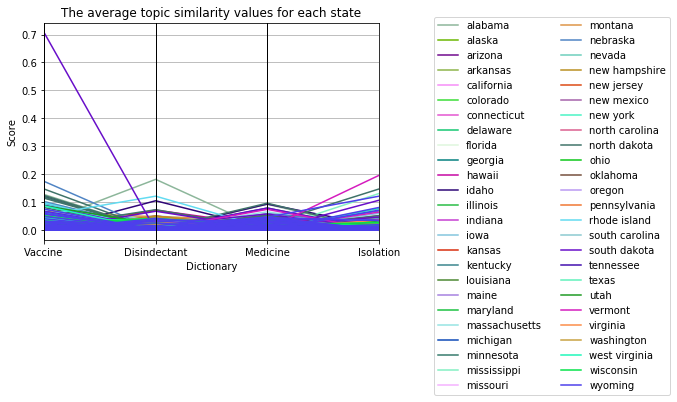

In [11]:
#Create parallel coordinates figure for each region
plt.figure()
pd.plotting.parallel_coordinates(state_day_panel_data.reset_index()[['state','vaccine_cosine_normal',	'disinfectant_cosine_normal',	'medicine_cosine_normal',	'isolation_cosine_normal']], 'state')

#Legend and title
plt.legend(bbox_to_anchor=(1.15, 1.05), ncol=2)
plt.title('The average topic similarity values for each state')
plt.xlabel('Dictionary')
plt.xticks([0,1,2,3], ['Vaccine', 'Disindectant', 'Medicine', 'Isolation'])
plt.ylabel('Score')
plt.show()

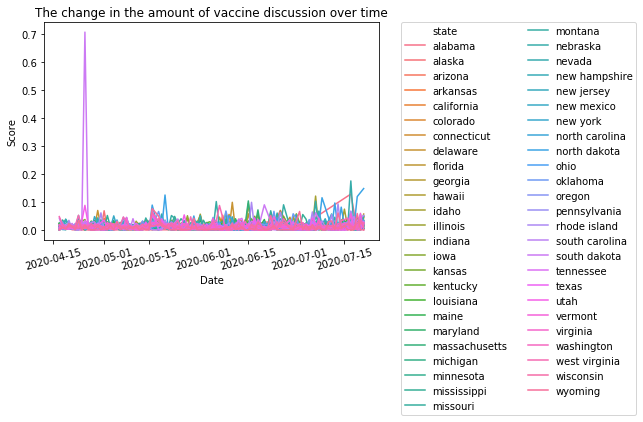

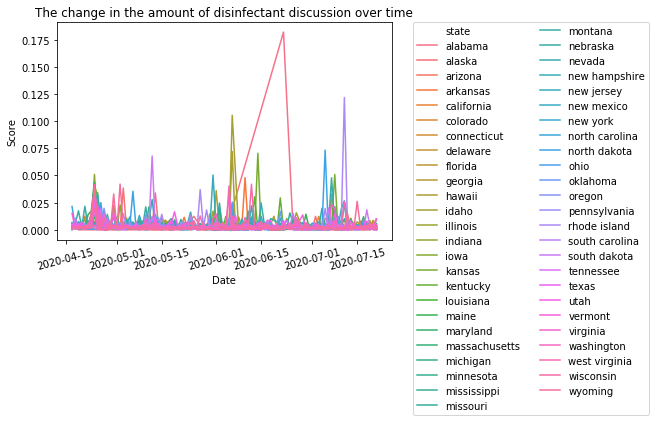

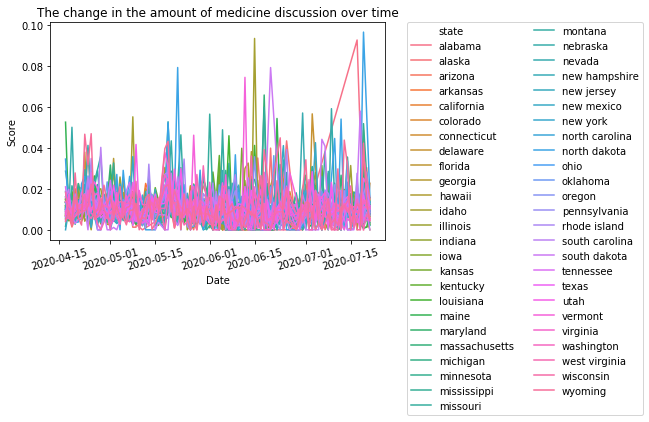

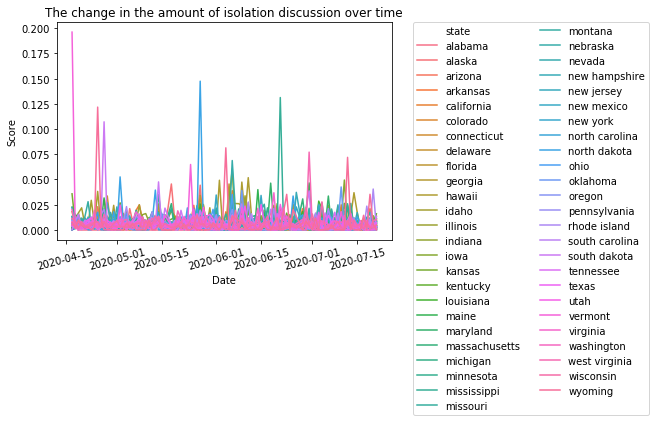

In [12]:
#Loop through each topic score and create figure for each topic in different states
for i in ['vaccine_cosine_normal', 'disinfectant_cosine_normal', 'medicine_cosine_normal', 'isolation_cosine_normal']:
    sns.lineplot(x= 'day', y= i,hue= "state", data= state_day_panel_data.reset_index())
        
    #Legend and title
    plt.legend(bbox_to_anchor= (1.05, 1.025), ncol= 2)
    plt.title('The change in the amount of {} discussion over time'.format(i.replace('_cosine_normal', '')))
    plt.xlabel('Date')
    plt.xticks(rotation= 15)
    plt.ylabel('Score')
    plt.show()

# Question 8:

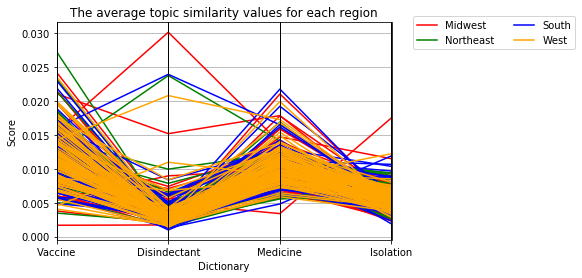

In [13]:
#Create parallel coordinates figure for each region
plt.figure()
pd.plotting.parallel_coordinates(region_day_panel_data.reset_index()[['region','vaccine_cosine_normal', 'disinfectant_cosine_normal', 'medicine_cosine_normal',	'isolation_cosine_normal']], 'region', color= ['r', 'g', 'b', 'orange'])
    
#Legend and title
plt.legend(bbox_to_anchor=(1.05, 1.05), ncol=2)
plt.title('The average topic similarity values for each region')
plt.xlabel('Dictionary')
plt.xticks([0,1,2,3], ['Vaccine', 'Disindectant', 'Medicine', 'Isolation'])
plt.ylabel('Score')
plt.show()

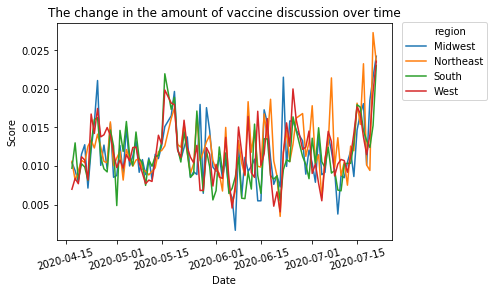

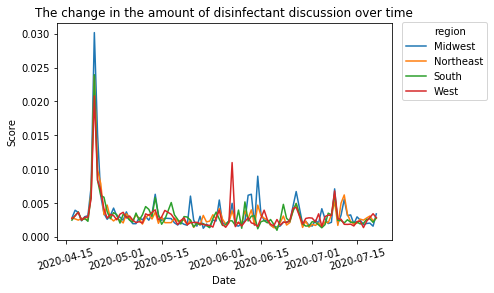

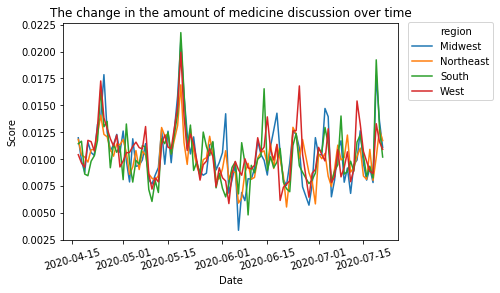

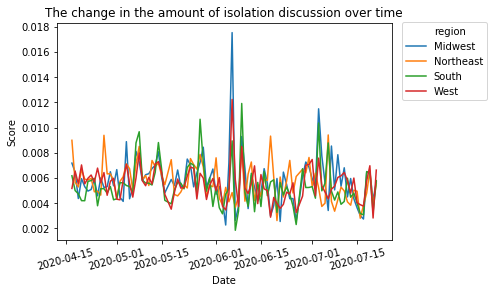

In [14]:
#Loop through each topic score and create figure for each topic in different regions
for i in ['vaccine_cosine_normal', 'disinfectant_cosine_normal', 'medicine_cosine_normal', 'isolation_cosine_normal']:
    sns.lineplot(x= 'day', y= i,hue= "region", data= region_day_panel_data.reset_index())
    
    #Legend and title
    plt.legend(loc= 'upper right', bbox_to_anchor= (1.3, 1.025))
    plt.title('The change in the amount of {} discussion over time'.format(i.replace('_cosine_normal', '')))
    plt.xlabel('Date')
    plt.xticks(rotation= 15)
    plt.ylabel('Score')
    plt.show()

# Question 9:

In [19]:
#Create a dateframe contains the mean of each score for each region
region_collapse= region_day_panel_data.reset_index().drop(['day'], axis = 1).groupby('region').mean()

#Create vector for each region
mw = list(region_collapse.loc['Midwest'])
ne = list(region_collapse.loc['Northeast'])
so = list(region_collapse.loc['South'])
we = list(region_collapse.loc['West'])

In [22]:
region = ['Midwest', 'Northeast', 'South', 'West']
vector = [mw, ne, so, we]

#Create Kolmogorov-Smirnov test result table
table = pd.DataFrame(data = None, index = region, columns= region)
for i in region:
    for j in range(4):
        for k in vector:
            table.loc[i][j] = stats.ks_2samp(vector[j], k)[1]

In [24]:
table

,Midwest,Northeast,South,West
Midwest,1,1,1,1
Northeast,1,1,1,1
South,1,1,1,1
West,1,1,1,1
